In [ ]:
#Install packages
#!pip install python-twitter
#!pip install TwitterAPI

In [1]:
# Import packages
import json
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from TwitterAPI import TwitterAPI
from nltk import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 

In [2]:
#train_file = "/Users/nescobar/Dropbox/Indiana/Social_Media_Mining/Project/smm2018/data/raw/csv/annotation/training_set_final_4.csv"
#test_file = "/Users/nescobar/Dropbox/Indiana/Social_Media_Mining/Project/smm2018/data/raw/csv/annotation/random_new_t.csv"

consumer_key = ''
consumer_secret = ''
access_token_key = ''
access_token_secret= ''

In [3]:
#api = TwitterAPI(consumer_key, consumer_secret, auth_type='oAuth2')

In [4]:
class ProcessTweets:
    
    def __init__(self):
        self.normalization = 'wn_lem'
        self._stopwords=set(stopwords.words('english')+list(punctuation)+['AT_USER','URL','IMG']
                                                                        +['twitter','com','twitter.com','pic','hurricaneharvey','harvey2017','harveyrelief','amp','houston','texas','harvey'])
        
    def get_data(query="", source="file", path=None, feed="search/tweets",api=None, maxid=0, n=100):
        try:
            if source == "file":
                harvey_df = pd.read_csv(path, encoding = 'ISO-8859-1')
                return harvey_df
            #else:
            #    if maxid == 0:
            #        return pd.read_json(json.dumps([t for t in api.request(feed, {'q':query,'count':n})]))
            #    else:
            #        return pd.read_json(json.dumps([t for t in api.request(feed, {'q': query, 'count': n, 'max_id': maxid})]))            
        except:
            print("Error while getting data")
            return None
    
    def process_tweets(self, list_of_tweets):
        processed_tweets=[]
        for tweet in list_of_tweets:
            processed_tweets.append((self._process_tweet(tweet)))
        return processed_tweets
    
    def set_normalization(self, new_norm):
        self.normalization = new_norm
    
    def _process_tweet(self,tweet):
        try:
            # Unescape from HTML
            #tweet = html.unescape(tweet)
            #tweet = BeautifulSoup(tweet, 'lxml').get_text()
            # 3a. Convert to lower case
            tweet = tweet.lower()
            # 3b. Replace links with the word URL 
            tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet) 
            # 3c. Replace @username with "AT_USER"
            tweet = re.sub('@[^\s]+',' ',tweet)                
            # 3d. Replace #word with word 
            tweet = re.sub(r'#([^\s]+)',r'\1',tweet)
            # 3e. Replace images with the word IMG 
            tweet = re.sub(r'\bpic.twitter.com\s+', ' ', tweet)
            # 3f Keep only words with letters
            tweet = re.sub('[^a-zA-Z]',' ',tweet)
            # 3g. Remove RT
            tweet = re.sub(r'\brt([\b\s])', ' ', tweet)
            
            # Apply Lemmatization
            if (self.normalization == 'wn_lem'):
                lemmatizer = WordNetLemmatizer() 
                tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if word not in self._stopwords and len(word)>1]  
            elif (self.normalization == 'lc_stem'):
                st = LancasterStemmer()
                tweet = [st.stem(word) for word in tweet.split() if word not in self._stopwords and len(word)>1]  
            elif (self.normalization == 'pt_stem'):
                pt = PorterStemmer()
                tweet = [pt.stem(word) for word in tweet.split() if word not in self._stopwords and len(word)>1]  
            else:
                lemmatizer = WordNetLemmatizer() 
                tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if word not in self._stopwords and len(word)>1]  
            
            return (" ".join(tweet)).strip()
        
        except:
            print("Error with tweet: ", tweet)
            return None

In [5]:
# Create train DF 
from sklearn.utils import shuffle
import pickle as pkl

# pt_stem, wn_lem, lc_stem
tweet_processor = ProcessTweets()
tweet_processor.set_normalization('wn_lem')
train_df = pkl.load(open("training_set.pkl", "rb"))
train_df['text'] = tweet_processor.process_tweets(train_df['text'])
train_df.columns = ['text','target']
train_df = shuffle(train_df)

In [6]:
# Testing with different classifiers
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Start running time
t0 = time()

# Build a pipeline that contains vectorizer, transform and classifier

ngram_range = (1,2)

# Multinomial NB
clf = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=ngram_range)),
                 ('clf', MultinomialNB()),
                ])
scores = cross_val_score(clf, train_df.text, train_df.target, cv=5)
print("Multinomial Naive Bayes: ", np.mean(scores))

# Logistic Regression
clf_lr = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=ngram_range)),
                 ('clf', LogisticRegression()),
                ])
scores = cross_val_score(clf_lr, train_df.text, train_df.target, cv=5, scoring='f1_weighted')
print("Logistic Regression: ", np.mean(scores))

# Logistic Regression with SGD 
clf_lr_sgd = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=ngram_range)),
                 ('clf', SGDClassifier(loss='log', penalty='l1',
                                            alpha=1e-3, random_state=42,
                                            max_iter=100, tol=None)),
                ])
scores = cross_val_score(clf_lr_sgd, train_df.text, train_df.target, cv=5, scoring='f1_weighted')
print("Logistic Regression with SGD: ", np.mean(scores))

# SVM
clf = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=ngram_range)),
                 ('clf', SVC()),
                ])
scores = cross_val_score(clf, train_df.text, train_df.target, cv=5, scoring='f1_weighted')
print("SVM: ", np.mean(scores))

# SVM with SGD (Stochastic Gradient Descent) 
clf = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=ngram_range)),
                 ('clf', SGDClassifier(loss='hinge', penalty='l1',
                                            alpha=1e-3, random_state=42,
                                            max_iter=100, tol=None)),
                ])
scores = cross_val_score(clf, train_df.text, train_df.target, cv=5, scoring='f1_weighted')
print("SVM with SGD: ", np.mean(scores))

# Print running time for training and predicting
print('Total running time', time() - t0)

Multinomial Naive Bayes:  0.925490196078
Logistic Regression:  0.956182886477
Logistic Regression with SGD:  0.94076569614
SVM:  0.936460239843
SVM with SGD:  0.944200943535
Total running time 0.8378751277923584


In [7]:
# Parameter tuning with Grid Search
from sklearn.model_selection import GridSearchCV

parameters = {'tfidf__ngram_range' : [(1,1),(1,2)],
             'clf__alpha': (1e-1, 1e-3, 1e-5),
             'clf__max_iter': (10,50,100),
             'clf__penalty': ('l1','l2','elasticnet'),
             'clf__fit_intercept': (True,False),
             'clf__class_weight': (None,'balanced'),
             'clf__warm_start': (True, False)
             }

gs_clf = GridSearchCV(clf_lr_sgd, parameters, n_jobs=-1)
gs_clf.fit(train_df.text, train_df.target)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.960784313725
{'clf__alpha': 0.001, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__max_iter': 10, 'clf__penalty': 'elasticnet', 'clf__warm_start': True, 'tfidf__ngram_range': (1, 2)}


In [9]:
from time import time
from sklearn.pipeline import Pipeline
from sklearn import metrics
import pickle as pkl
import numpy as np

# Start running time
t0 = time()

pkl_files = ['harvey_august_2017.pkl', 'harvey_september_2017.pkl', 'harvey_oct_dec_2017.pkl'
            ,'harvey_january_2018.pkl','harvey_february_2018.pkl', 'harvey_march_2018.pkl', 
             'harvey_april_2018.pkl']

print(gs_clf.classes_)

# Loop over each .pkl file
for file in pkl_files:
    harvey_recent_df = pkl.load(open(file, "rb"))
    harvey_recent_df.drop_duplicates('text', inplace=True)
    harvey_recent_df.text = tweet_processor.process_tweets(harvey_recent_df.text)
    predicted = gs_clf.predict_proba(harvey_recent_df.text)
    
    c_donation=c_other=c_relocation=c_volunteering=c_na=0
    
    # Consider only predictions with > 0.5 probability
    for tweet, category in zip(harvey_recent_df.text, predicted):
        
        if category[0] > 0.5:
            c_donation += 1
        elif category[1] > 0.5:
            c_relocation += 1    
        elif category[2] > 0.5:
            c_volunteering += 1
        else:
            c_na += 1

    total_tweets = len(harvey_recent_df.text)
    print("File: ", file)
    print("Total tweets analyzed:", total_tweets)
    print("Total tweets classified as DONATION: {} {}%"
            .format(c_donation, np.around((c_donation/total_tweets)*100),decimals=2))
    print("Total tweets classified as RELOCATION: {} {}%"
            .format(c_relocation, np.around((c_relocation/total_tweets)*100),decimals=2))
    print("Total tweets classified as VOLUNTEERING: {} {}%"
            .format(c_volunteering, np.around((c_volunteering/total_tweets)*100),decimals=2))
    print("Total tweets classified as NOT CLASSIFIED: {} {}%"
            .format(c_na, np.around((c_na/total_tweets)*100),decimals=2))

    print("*"*50)
    
print('Total running time', time() - t0)

['donation' 'relocation' 'volunteering']
File:  harvey_august_2017.pkl
Total tweets analyzed: 984
Total tweets classified as DONATION: 208 21.0%
Total tweets classified as RELOCATION: 40 4.0%
Total tweets classified as VOLUNTEERING: 37 4.0%
Total tweets classified as NOT CLASSIFIED: 699 71.0%
**************************************************
File:  harvey_september_2017.pkl
Total tweets analyzed: 987
Total tweets classified as DONATION: 232 24.0%
Total tweets classified as RELOCATION: 13 1.0%
Total tweets classified as VOLUNTEERING: 35 4.0%
Total tweets classified as NOT CLASSIFIED: 707 72.0%
**************************************************
File:  harvey_oct_dec_2017.pkl
Total tweets analyzed: 949
Total tweets classified as DONATION: 96 10.0%
Total tweets classified as RELOCATION: 24 3.0%
Total tweets classified as VOLUNTEERING: 37 4.0%
Total tweets classified as NOT CLASSIFIED: 792 83.0%
**************************************************
File:  harvey_january_2018.pkl
Total tweets 

In [10]:
train_df.groupby(['target']).size()

target
donation        85
relocation      85
volunteering    85
dtype: int64

In [46]:
import operator
coefs = [] 
words = []

tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2))
tfidf_vectorizer.fit_transform(train_df.text)

clf_lr_sgd.fit(train_df.text, train_df.target)

# Create list of coefficients and words
for k,v in tfidf_vectorizer.vocabulary_.items():
    coefs.append(clf_lr_sgd.named_steps['clf'].coef_[0][tfidf_vectorizer.vocabulary_[k]])
    words.append(k)

# Create pairs of (words, coefficients)
pairs = []
for p in zip(words, coefs): 
    pairs.append(p)

# Sort pairs by coefficient
pairs.sort(reverse=True, key=operator.itemgetter(1))

top_coef_words = []
top_coef_values = []
# Print words with highest coefficients 
#[print(k,v) for k,v in pairs[:10]]
for k,v in pairs[:10]:
    top_coef_words.append(k)
    top_coef_values.append(v)
    
pairs.sort(reverse=False, key=operator.itemgetter(1))

bottom_coef_words = []
bottom_coef_values = []
# Print words with highest coefficients 
#[print(k,v) for k,v in pairs[:10]]
for k,v in pairs[:10]:
    bottom_coef_words.append(k)
    bottom_coef_values.append(v)


In [29]:
#Top ngrams in tweets
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

vect = TfidfVectorizer(ngram_range=(1,2))

summaries_donation = "".join([tweet for tweet, category in zip(harvey_recent_df.text, predicted) if category[0]>0.5])
summaries_relocation = "".join([tweet for tweet, category in zip(harvey_recent_df.text, predicted) if category[1]>0.5])
summaries_volunteering = "".join([tweet for tweet, category in zip(harvey_recent_df.text, predicted) if category[2]>0.5])

ngrams_summaries_donation = vect.build_analyzer()(summaries_donation)
ngrams_summaries_relocation = vect.build_analyzer()(summaries_relocation)
ngrams_summaries_volunteering = vect.build_analyzer()(summaries_volunteering)

top20_donation = [ngram for ngram in Counter(ngrams_summaries_donation).most_common(20) ]
top20_relocation = [ngram for ngram in Counter(ngrams_summaries_relocation).most_common(20) ]
top20_volunteering = [ngram for ngram in Counter(ngrams_summaries_volunteering).most_common(20) ]

In [30]:
# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

In [31]:
top_words_donation = [x[0] for x in top20_donation]
top_frequencies_donation = [x[1] for x in top20_donation]

top_words_relocation = [x[0] for x in top20_relocation]
top_frequencies_relocation = [x[1] for x in top20_relocation]

top_words_volunteering = [x[0] for x in top20_volunteering]
top_frequencies_volunteering = [x[1] for x in top20_volunteering]

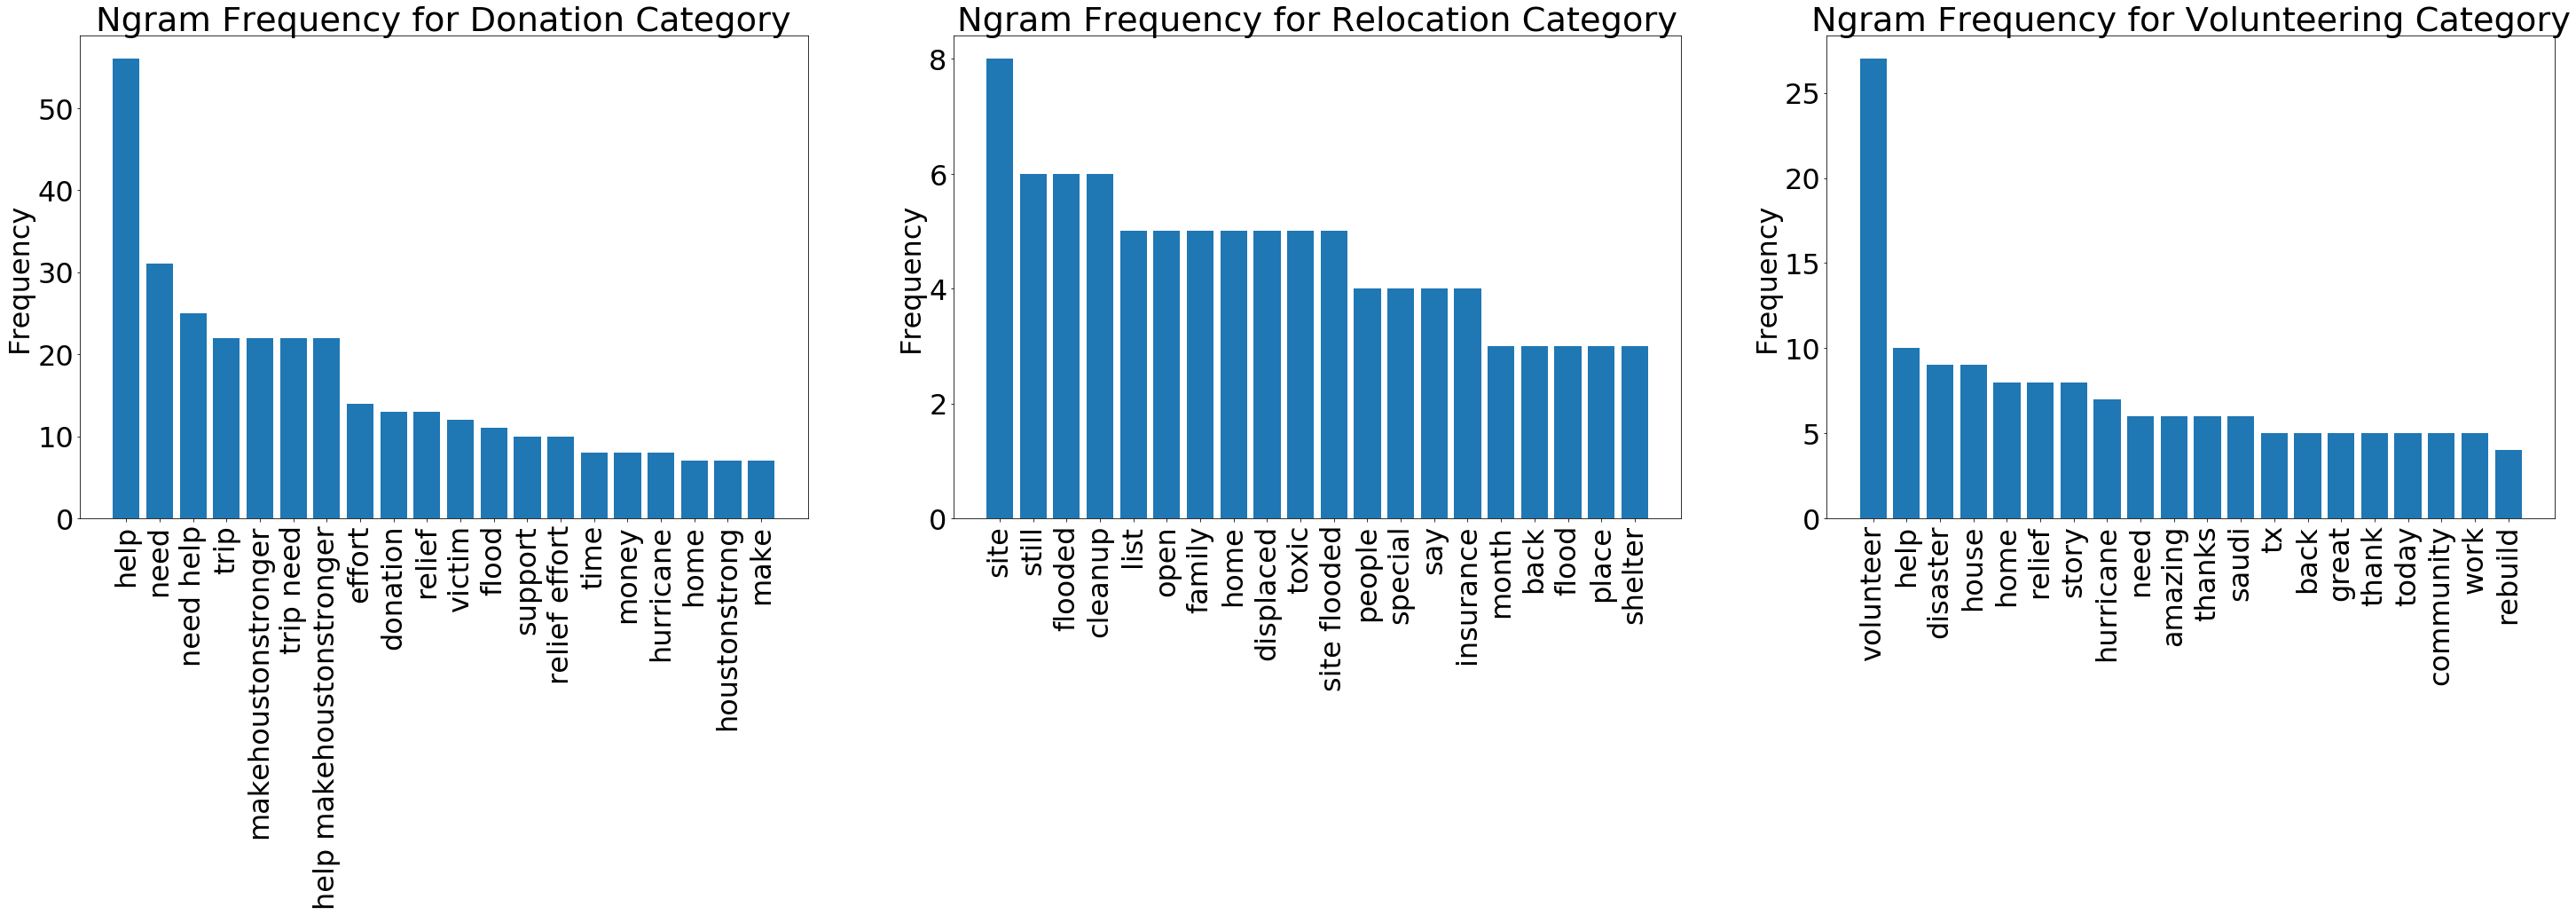

In [44]:
plt.figure(figsize=(50,10))
plt.rcParams.update({'font.size': 32})

plt.subplot(1,3,1)
x_positions = np.arange(20)
plt.bar(x_positions, top_frequencies_donation)
plt.xticks(x_positions, top_words_donation, rotation=90)
plt.title("Ngram Frequency for Donation Category")
plt.ylabel("Frequency")

plt.subplot(1,3,2)
plt.bar(x_positions, top_frequencies_relocation)
plt.xticks(x_positions, top_words_relocation, rotation=90)
plt.title("Ngram Frequency for Relocation Category")
plt.ylabel("Frequency")

plt.subplot(1,3,3)
plt.bar(x_positions, top_frequencies_volunteering)
plt.xticks(x_positions, top_words_volunteering, rotation=90)
plt.title("Ngram Frequency for Volunteering Category")
plt.ylabel("Frequency")

plt.show()

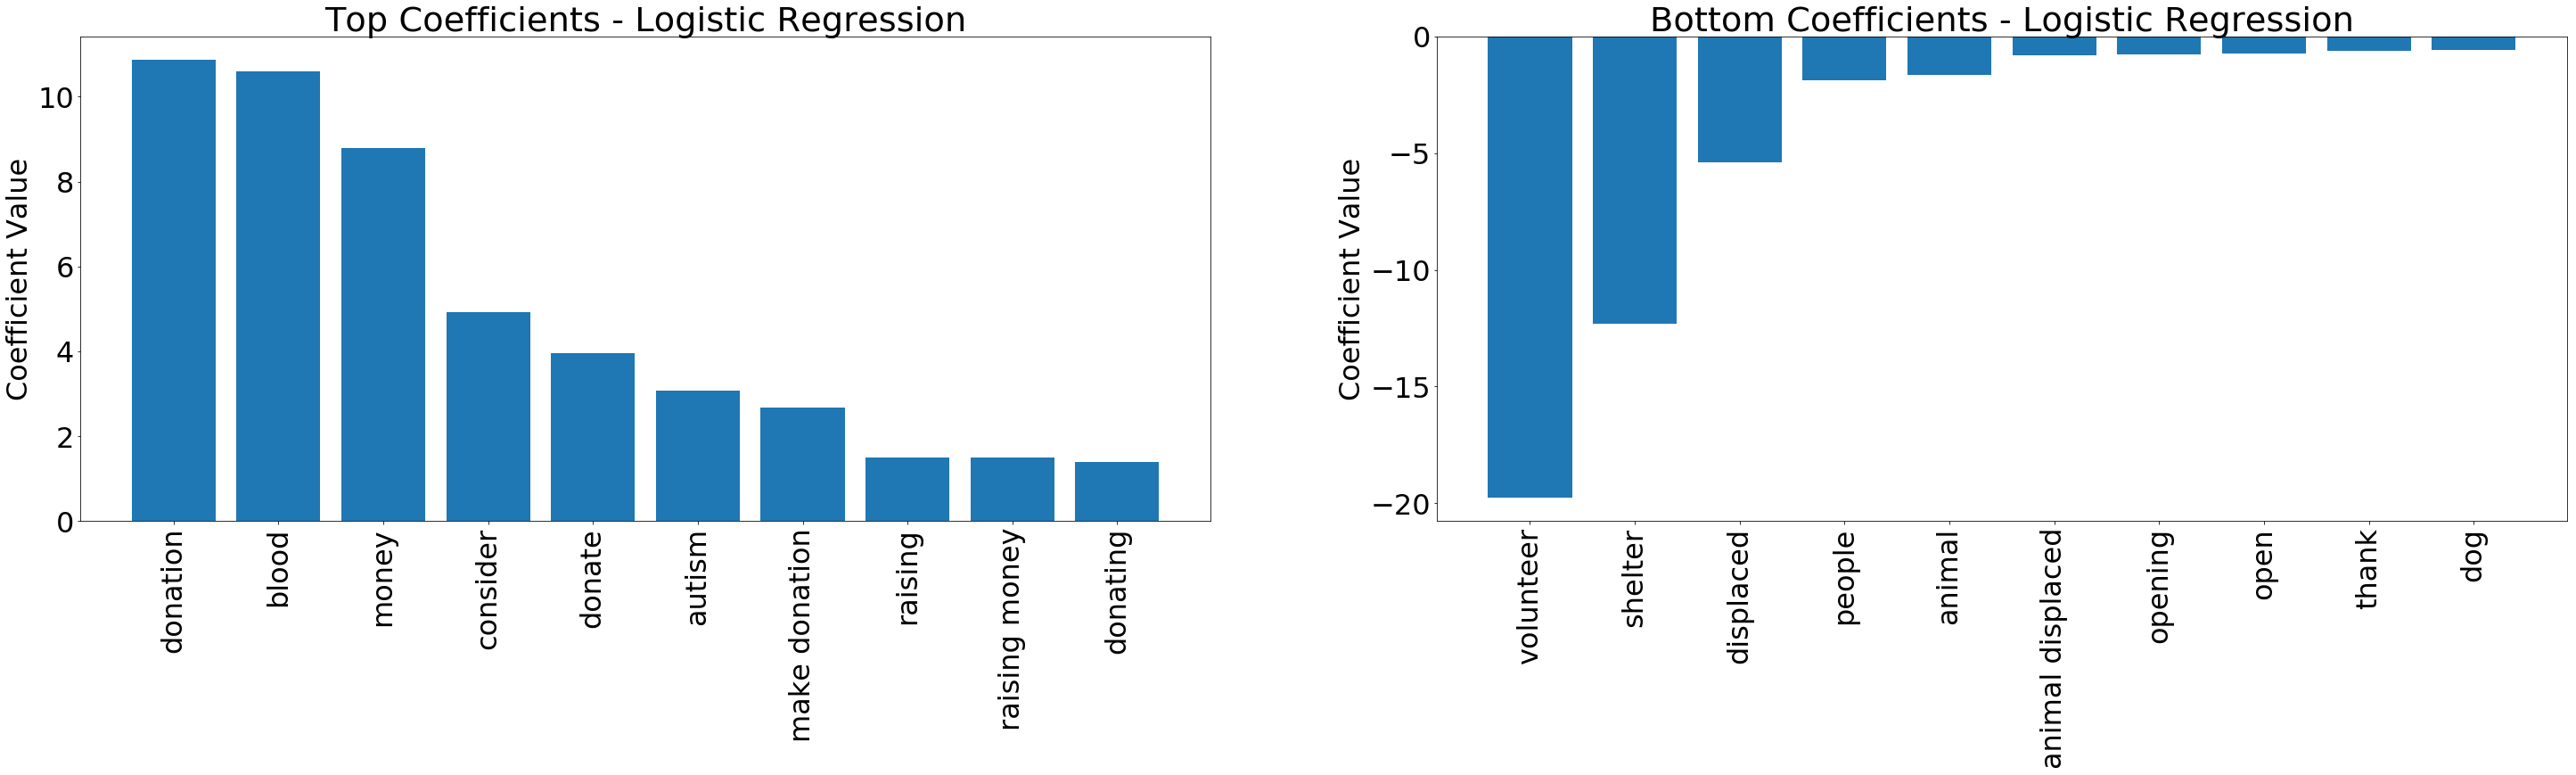

In [50]:
plt.figure(figsize=(50,10))
plt.rcParams.update({'font.size': 32})

plt.subplot(1,2,1)
x_positions = np.arange(10)
plt.bar(x_positions, top_coef_values)
plt.xticks(x_positions, top_coef_words, rotation=90)
plt.title("Top Coefficients - Logistic Regression")
plt.ylabel("Coefficient Value")

plt.subplot(1,2,2)
plt.bar(x_positions, bottom_coef_values)
plt.xticks(x_positions, bottom_coef_words, rotation=90)
plt.title("Bottom Coefficients - Logistic Regression")
plt.ylabel("Coefficient Value")

plt.show()